In [1]:
# Sample API
import flowx
import simulation
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 100, 50
xmin, xmax = -3.0, 7.0
ymin, ymax = -2.5, 2.5

Re   = 100.0
dt   = 1e-1
tmax = 2.

ibm_x = 0.0
ibm_y = 0.0
ibm_r = 0.5

# Define cell-centered variable names
center_vars = ['pres', 'divv']
face_vars   = ['velc', 'hvar']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=2.0, dt=0.01, Re=100.0)

In [3]:
simulation.set_initial_velocity(gridc, gridx, gridy, 'velc', 'pres')

------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.9236406170156e-13
Max, Min, U   : 1.0306988957986423, -1.0
Max, Min, V   : 0.05957812727760613, -0.05957812727760613
Max, Min, P   : 0.7609521871502062, -0.23944529813825285
Max, Min, DIV : 2.7087707077377843e-15, -2.592869495499084e-15


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.409800876027771e-13
Max, Min, U   : 1.044110136690312, -1.0
Max, Min, V   : 0.08500202661993257, -0.08500202661993261
Max, Min, P   : 0.7257454950575449, -0.13743986662936333
Max, Min, DIV : 2.467644144577008e-15, -2.2551405187698492e-15


------------ Time = 0.3000000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.783924417928984e-13
Max, Min, U   : 1.0615027082521644, -1.0
Max, Min, V   : 0.10149747456943667, -0.10149747456943671
Max, Min, P   : 0.7114222672519476, -

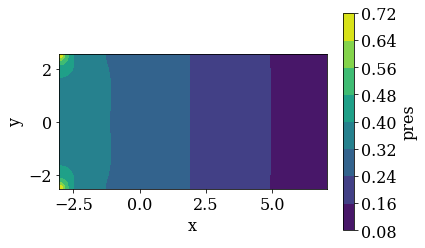

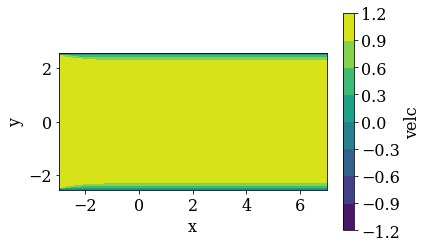

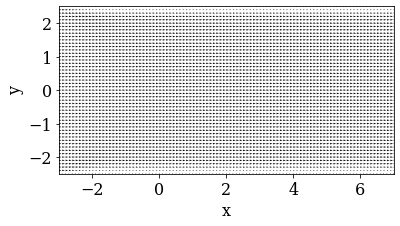

------------ Time = 1.1000000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.1728574931424252e-12
Max, Min, U   : 1.120745957803591, -1.0
Max, Min, V   : 0.11676729213076732, -0.116767292130767
Max, Min, P   : 0.7089164518442378, 0.13716550349082152
Max, Min, DIV : 2.387846864682075e-15, -2.2898349882893854e-15


------------ Time = 1.2000000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2869048865991164e-12
Max, Min, U   : 1.1234800747190108, -1.0
Max, Min, V   : 0.11765997294399674, -0.11765997294399672
Max, Min, P   : 0.7280856392084034, 0.16509766789559036
Max, Min, DIV : 2.4791366876053544e-15, -2.4980018054066022e-15


------------ Time = 1.300000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.1001371119825431e-12
Max, Min, U   : 1.1254766341127111, -1.0
Max, Min, V   : 0.11827846695743108, -0.11827846695743104
Max, Min, P   : 0.6883918254131531, 0.

In [4]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')

# Compute mass in the domain
Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
       simulation.get_qin(gridy, 'velc', bc_type_v['velc']))

# Update the outflow boundary velocity using a convective equation.
simulation.update_outflow_bc(gridx, 'velc', dt)

# Predictor Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

# Divergence Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')

# Compute mass out of the domain
Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
        simulation.get_qout(gridy, 'velc', bc_type_v['velc']))

# Rescale velocity at outflow and update BC for corrector step
simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                            Qin, Qout) 
simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)

# Solve the pressure Poisson equation 
scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                         poisson_options)


# Corrector Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')

scalars.advance()

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    # Compute mass in the domain
    Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
           simulation.get_qin(gridy, 'velc', bc_type_v['velc']))
    
    # Update the outflow boundary velocity using a convective equation.
    simulation.update_outflow_bc(gridx, 'velc', dt)
    
    # Predictor Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'predictor')
    
    # Divergence Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'divergence')
    
    # Compute mass out of the domain
    Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qout(gridy, 'velc', bc_type_v['velc']))
    
    # Rescale velocity at outflow and update BC for corrector step
    simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                Qin, Qout) 
    simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                             poisson_options)
    
    
    # Corrector Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)  
        
    if scalars.variable['nstep'] % 100 == 0:
        flowx.io.plot_contour(gridc, 'pres')
        flowx.io.plot_contour(gridx, 'velc')
        flowx.io.plot_vector(gridx,gridy,'velc')
              
    scalars.advance()

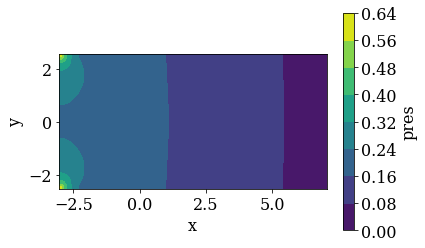

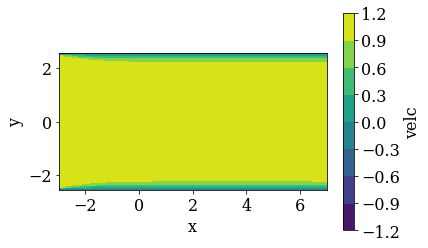

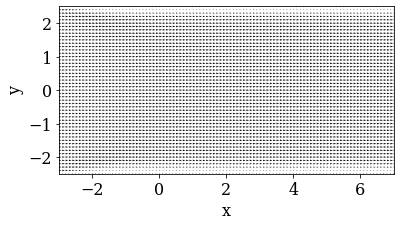

In [5]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_vector(gridx,gridy,'velc')